<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>
<hr/>
<font color="#800080" size=5>
Assignment 1 : Deep Autoregressive Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
<hr>
<font color='red'  size=4>
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @imoonamm
</font>
<br>
<hr>
</div></font>

**You should only change the blank sections, marked with TODO**

Pay attention to docstrings, as they may drastically help with your implementation.

You are advised to read all related papers and material, to help you better understand the design of each model.

# Question 1: WaveNet : A generative model for raw audio

WaveNet is a general purpose technology that has allowed us to unlock a range of new applications, from improving video calls on even the weakest connections to helping people regain their original voice after losing the ability to speak.

![Local GIF](unnamed.gif)

WaveNet models raw audio waveforms autoregressively:
$
p(x_{1:T}) = \prod_{t=1}^T p(x_t \mid x_{<t})
$
\
Instead of predicting spectrograms or using a vocoder, WaveNet predicts the next audio sample directly (often after µ-law companding and 8-bit/256-way quantization). This yields very natural sounding speech and music because the network learns the waveform structure end-to-end.

## 2. Core

### 2.1 Causal convolutions
A causal 1D convolution ensures predictions at time \(t\) don't depend on future samples:
- Achieved by padding only on the left (past).
- In practice, use `padding = dilation * (kernel_size - 1)` and then trim the rightmost elements (or use `Chomp1d` cropping).

### 2.2 Dilated convolutions
Dilations `[1, 2, 4, 8, ...]` in stacked layers let the receptive field grow exponentially with depth while keeping the number of parameters manageable. A stack of several cycles of dilations covers long temporal context (hundreds to thousands of samples).

### 2.3 Gated activation units
Each residual block uses a gated unit:
$
\text{z} = \tanh(W_f * x) \odot \sigma(W_g * x)
$
where `*` is dilated causal conv, `W_f` and `W_g` are convolution filters. The output splits to (1) residual connection and (2) skip connection that is added to final output.

### 2.4 Residual & skip connections
- Residual: `x_{l+1} = x_l + \text{residual\_out}` to ease training.
- Skip: every block outputs a skip tensor; all skip outputs are summed, then passed through post-processing (ReLU, Conv, softmax) to produce the final distribution over quantized samples.

### 2.5 Output quantization / softmax
Audio samples are often µ-law quantized to 256 values; WaveNet predicts a categorical distribution (`softmax(256)`) over those values for each time step. Continuous outputs are also possible (mixture of logistics / Gaussians) but discrete softmax is standard in the original paper.

### 2.6 Conditioning
- **Global conditioning**: a per-utterance vector (e.g., speaker id embedding) is added to layer activations.
- **Local conditioning**: low-rate features (e.g., mel spectrogram) are upsampled (transposed conv / nearest) and added at each time step.

---

## 3. Training & sampling

### Training
- Teacher forcing: at training time the network receives true previous samples and learns to predict the next sample with cross-entropy loss (if quantized).
- Batch size and optimization: use Adam, gradient clipping recommended for stability.
- Preprocess: µ-law companding + 256-level quantization is common.

### Sampling (inference)
- Autoregressive generation: sample one sample at a time and feed it back.
- Slow by default — many acceleration techniques exist (distillation → Parallel Wavenet, caching convolutions, WaveRNN, etc.).



**Reference:** [WaveNet: A Generative Model for Raw Audio* (van den Oord et al., DeepMind, 2016)](https://arxiv.org/abs/1609.03499)


In [19]:
!pip install -q torchaudio
# !pip install git+git://github.com/pytorch/audio
import torchaudio
import os

In [20]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import ModuleList
from IPython.display import Audio
from torch.autograd import Variable
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### at first you must convert input into One Hot vector

5 Points


In [21]:
import torch.nn.functional as F

class OneHot(nn.Module):
    def __init__(self, MU):
        super(OneHot,self).__init__()
        self.MU = MU
        self.ones = None

    def forward(self, x):
        #TODO

        # n, c = x.shape
        # Ensure the tensor is of type LongTensor (required for one-hot encoding)
        x = x.long()

        # one_hot = F.one_hot(x.view(n*c, 1), self.MU).type(torch.float).permute(0, 2, 1)

        # Ensure the values are within the correct range [0, MU-1] (class indices)
        x = torch.clamp(x, 0, self.MU - 1)

        # Apply one-hot encoding and convert to float
        x_one_hot = F.one_hot(x, num_classes=self.MU).float().permute(0, 2, 1)
        return x_one_hot

    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.MU)

Before diving into the WaveNet model itself, it’s important to understand what kind of **data** we are modeling — **raw audio waveforms**.  
Neural networks can only process numbers, so we need to represent sound in a numerical form that captures its essential structure and variation.

---

## 1. Sampling Rate and Bit Depth

### Sound as a Signal
Sound in the real world is a **continuous analog waveform** — a pressure signal that varies smoothly over time.  
To process it digitally, we **sample** it: we take discrete measurements of the amplitude at equally spaced time intervals.

This process converts a continuous signal into a **time series of numbers**:
$
x = [x_1, x_2, \dots, x_T]
$
where each \(x_t\) represents the air pressure (or voltage) at time step \(t\).

---

### Sampling Rate
The **sampling rate** defines **how many times per second** we measure the amplitude of the signal.  
Typical values:
- CD quality audio: 44,100 Hz (samples per second)
- Speech datasets: 16,000 Hz or 22,050 Hz

A higher sampling rate means more detail, but also more data to process.  
WaveNet typically models 16 kHz or 22 kHz audio for speech generation tasks.

---

### Bit Depth
Each recorded sample must be represented by a finite number of bits.  
The **bit depth** determines the range and precision of these values:
- 8-bit → 256 possible levels  
- 16-bit → 65,536 levels  
- 24-bit → 16,777,216 levels  

The bit depth affects the **signal-to-noise ratio (SNR)** — higher bit depth means less quantization noise and a larger dynamic range:
$
\text{SNR} \approx 6.02 \times \text{bit depth} + 1.76\ \text{dB}
$

For example:
- 8-bit ≈ 49.9 dB SNR  
- 16-bit ≈ 98 dB SNR

---

## 2. From Audio to Time Series

After digitization, the audio signal becomes a **sequence of numbers over time**, also known as a **time series**.  
Each point depends on previous ones — this temporal dependency is what WaveNet models autoregressively:
$
p(x_{1:T}) = \prod_{t=1}^{T} p(x_t \mid x_{<t})
$

However, raw 16-bit audio contains **too many values** (65,536 possible amplitudes).  
Predicting the exact next value among that huge range is extremely hard for a neural network.

To simplify, we reduce this dynamic range to a smaller set — typically **256 levels** — using a technique called **µ-law companding**.

---

## 3. µ-law Quantization (Companding Transformation)

### Motivation
Human hearing follows the **Weber–Fechner law** — our perception of changes in loudness is **logarithmic**, not linear.  
That means we are more sensitive to small amplitude changes in quiet sounds than in loud ones.

µ-law companding exploits this property by **compressing the amplitude range logarithmically** —  
it allocates more resolution to small signals (quiet sounds) and less to large ones.

---

### µ-law Formula

$
f(x) = \text{sign}(x) \cdot \frac{\ln(1 + \mu |x|)}{\ln(1 + \mu)}, \quad -1 \le x \le 1
$

where:
- \(x\) = input waveform (normalized to [-1, 1])  
- \(\mu\) = companding constant (usually 255 for 8-bit quantization)

After applying µ-law, we map the range \([-1, 1]\) to discrete integer values \([0, 255]\).

---


## Defining Wavenet

20 Points

The following figure describes the overall architecture of WaveNet. Note that Transformers were non-existent in 2016!

![Wavenet Arch](WaveNet.png)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 dilation=1,
                 **kwargs):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, 
                              out_channels, 
                              kernel_size, 
                              padding=self.padding, 
                              dilation=dilation, 
                              bias=False, 
                              **kwargs)
    
    def forward(self, input_):
        return self.conv(input_)[:, :, :-self.padding] if self.padding else self.conv(input_)


class GatedActivationUnit(nn.Module):
    def __init__(self):
        super(GatedActivationUnit, self).__init__()
    
    def forward(self, input_):
        return torch.tanh(input_) * torch.sigmoid(input_)

class Wavenet(nn.Module):
    def __init__(self, dilation_depth, n_blocks, n_dil_channels, n_residual_channels,
                 n_skip_channels, n_category, kernel_size, bias=False):
        super(Wavenet, self).__init__()
        
        # Store parameters
        self.dilation_depth = dilation_depth
        self.n_blocks = n_blocks
        self.n_dil_channels = n_dil_channels
        self.n_residual_channels = n_residual_channels
        self.n_skip_channels = n_skip_channels
        self.n_category = n_category
        self.kernel_size = kernel_size
        self.One_hot = OneHot(n_category)
        
        # Initial convolution to process the input data
        self.start_conv = nn.Conv1d(in_channels=self.n_category,
                                     out_channels=self.n_residual_channels, 
                                     kernel_size=self.kernel_size, 
                                     padding=(self.kernel_size - 1) // 2, 
                                     bias=bias)
        
        # Stack of dilated convolutions
        self.stack = nn.ModuleList()
        for b in range(self.n_blocks):
            dilation = 1
            for k in range(self.dilation_depth):
                layer = nn.Sequential(
                    CausalConv1d(in_channels=self.n_residual_channels,
                                 out_channels=self.n_dil_channels, 
                                 kernel_size=self.kernel_size,
                                 dilation=dilation),
                    GatedActivationUnit(),
                    nn.Conv1d(in_channels=self.n_dil_channels, 
                              out_channels=self.n_residual_channels, 
                              kernel_size=1, 
                              bias=bias)
                )
                self.stack.append(layer)
                dilation *= 2
        
        # Final convolutions for the skip connections and output
        self.end_conv = nn.Sequential(
            nn.ReLU(), 
            nn.Conv1d(in_channels=self.n_residual_channels, 
                      out_channels=self.n_skip_channels, 
                      kernel_size=1, 
                      bias=bias),
            nn.ReLU(),
            nn.Conv1d(in_channels=self.n_skip_channels, 
                      out_channels=self.n_category, 
                      kernel_size=1, 
                      bias=bias)
        )

    def forward(self, x):
        """
        Forward pass through the WaveNet model.
        x: Input tensor (batch_size, time_steps)
        """
        # Apply one-hot encoding
        x = self.One_hot(x)
        # x = x.unsqueeze(1)  # Add channel dimension (batch_size, 1, time_steps)
        
        # Initial convolution
        residual = self.start_conv(x)
        skips = torch.zeros_like(residual)  # To accumulate skip connections
        
        # Loop through the stack of dilated convolutions
        for layer in self.stack:
            skip = layer(residual)
            residual = residual + skip  # Residual connection
            skips = skips + skip  # Skip connection aggregation

        # Final output from the skip connections
        logit = self.end_conv(skips)
        return logit

    def generate(self, input, num_samples=100):
        """
        Generate samples autoregressively.
        input: Initial input to start the generation.
        num_samples: Number of samples to generate.
        """
        # Input should be a tensor of size (batch_size, 1, time_steps)
        generated = input
        
        # Generate samples one at a time
        for _ in range(num_samples):
            # Get the model's prediction for the next time step
            output = self.forward(generated)
            
            # Get the softmax probabilities for the next sample
            probabilities = F.softmax(output[:, :, -1], dim=-1)
            
            # Sample the next value from the probability distribution
            next_sample = torch.multinomial(probabilities, 1)
            
            # Append the predicted sample to the generated sequence
            generated = torch.cat((generated, next_sample.unsqueeze(0)), dim=-1)
        
        return generated.squeeze(0).transpose(0, 1)


Quantization of 16 bit audio

5 Points

In [23]:
def mulaw_quantize(x, qc):
    """
    Apply µ-law quantization to the input waveform.

    Parameters:
    x (tensor): Input waveform (usually between -1 and 1).
    qc (int): Number of quantization channels (usually 256).

    Returns:
    tensor: Quantized waveform.
    """
    # Apply µ-law companding
    x_mu = mu_law_companding_transformation(x, mu=qc - 1)

    # Scale to the range [0, qc-1] and quantize
    x_mu = (x_mu + 1) * (qc // 2)  # Scale to the range [0, qc-1]
    x_mu = torch.clamp(torch.round(x_mu), 0, qc - 1).long()  # Quantize and clamp to [0, qc-1]
    
    return x_mu

Inverse quantization

5 Points

In [24]:
def inv_mulaw_quantize(x_mu, quantization_channels=256, device='cpu'):
    """
    Apply inverse µ-law quantization to recover the original waveform.

    Parameters:
    x_mu (tensor): Quantized waveform (indices).
    quantization_channels (int): Number of quantization levels (usually 256).
    device (str): Device for tensor computation (e.g., 'cpu' or 'cuda').

    Returns:
    tensor: Recovered waveform.
    """
    # Inverse scaling of the quantized values to [0, 1]
    x_mu = x_mu.float() / (quantization_channels - 1)  # Normalize to [0, 1]
    
    # Apply inverse µ-law companding
    x = inverse_mu_law_companding_transformation(x_mu * 2 - 1, mu=quantization_channels - 1)
    
    return x

## Load Dataset
In this part you must load the audio_dataset.npz that exist in zip file of homework

10 Points

In [25]:
import os
import os.path
import math
import threading
import torch
import torch.utils.data
import numpy as np
import librosa as lr
import bisect


class WavenetDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_file,
                 item_length,
                 target_length,
                 file_location=None,
                 classes=256,
                 sampling_rate=16000,
                 mono=True,
                 normalize=False,
                 dtype=np.uint8,
                 train=True,
                 test_stride=100):

        #           |----receptive_field----|
        #                                 |--output_length--|
        # example:  | | | | | | | | | | | | | | | | | | | | |
        # target:                           | | | | | | | | | |

        self.dataset_file = dataset_file
        self._item_length = item_length
        self._test_stride = test_stride
        self.target_length = target_length
        self.classes = classes

        if not os.path.isfile(dataset_file):
            assert file_location is not None, "no location for dataset files specified"
            self.mono = mono
            self.normalize = normalize

            self.sampling_rate = sampling_rate
            self.dtype = dtype
            self.create_dataset(file_location, dataset_file)
        else:
            # Unknown parameters of the stored dataset
            data = np.load(dataset_file, mmap_mode='r')
            
            # TODO Can these parameters be stored, too?
            self.mono = data.get('mono', None)
            self.normalize = data.get('normalize', None)
            self.sampling_rate = data.get('sampling_rate', None)
            self.dtype = data.get('dtype', None)

            if self.mono is None or self.sampling_rate is None or self.dtype is None:
                raise ValueError("The dataset file is missing essential parameters such as mono, sampling_rate, or dtype.")


        self.data = np.load(self.dataset_file, mmap_mode='r')
        self.start_samples = [0]
        self._length = 0
        self.calculate_length()
        self.train = train
        print("one hot input")
        # assign every *test_stride*th item to the test set


    def calculate_length(self):
        start_samples = [0]
        for i in range(len(self.data.keys())):
            start_samples.append(start_samples[-1] + len(self.data['arr_' + str(i)]))
        available_length = start_samples[-1] - (self._item_length - (self.target_length - 1)) - 1
        self._length = math.floor(available_length / self.target_length)
        self.start_samples = start_samples

    def set_item_length(self, l):
        self._item_length = l
        self.calculate_length()

    def __getitem__(self, idx):
        # TODO: Clarify sample_index calculation for train/test with test_stride
        file_index = bisect.bisect_right(self.start_samples, idx) - 1

        # TODO: Check file_index bounds; currently prints error, consider raising IndexError
        if file_index < 0 or file_index >= len(self.data.keys()):
            raise IndexError(f"File index {file_index} is out of bounds.")

        # Get the start and end positions for the sample in the selected file
        file_start = self.start_samples[file_index]
        start_sample = idx - file_start
        end_sample = start_sample + self._item_length
    
        # Cache the data by loading it once in the __init__ method
        file_data = self.data['arr_' + str(file_index)]
        
        if end_sample <= len(file_data):
        # TODO: Avoid repeated np.load calls; cache self.data in __init__ instead
            data = file_data[start_sample:end_sample]

        else:
            # TODO: Optimize cross-file slicing; currently concatenates arrays which copies memory
            data = np.concatenate((file_data[start_sample:], 
                self.data['arr_' + str(file_index + 1)][: end_sample - len(file_data)]))

        
        # Quantize data (using previously defined quantization function)
        quantized_data = quantize_data(data, self.classes)
        
        # TODO: One-hot creation is memory heavy; consider returning integer indices and use nn.Embedding in model
        input_data = torch.tensor(quantized_data[:-self.target_length])  # All except the last target_length samples
        target_data = torch.tensor(quantized_data[-self.target_length:])  # The last target_length samples are the target
    
        # One-hot encode the input (to avoid high memory usage, we'll use nn.Embedding in the model)
        one_hot = F.one_hot(input_data, self.classes).float().transpose(0, 1)
        target = F.one_hot(target_data, self.classes).float().transpose(0, 1)

        return one_hot, target


    def __len__(self):
        test_length = math.floor(self._length / self._test_stride)
        if self.train:
            return self._length - test_length
        else:
            return test_length


def quantize_data(data, classes):
    #TODO
    data = mu_law_encoding(data, mu=classes-1)
    quantized = np.floor((data + 1) * (classes / 2)).astype(int)
    return quantized


def list_all_audio_files(location):
    #TODO
    audio_files = []
    for root, dirs, files in os.walk(location):
        for file in files:
            if file.endswith(".wav") or file.endswith(".flac"):
                audio_files.append(os.path.join(root, file))
    return audio_files


def mu_law_encoding(data, mu=255):
    """
    Apply µ-law encoding to the input data.

    Parameters:
    - data (tensor): The input data (PyTorch tensor).
    - mu (int): The µ-law parameter (default 255 for 8-bit quantization).

    Returns:
    - mu_x (tensor): The µ-law encoded data.
    """
    # Normalize the data to the range [-1, 1]
    data = torch.clamp(data, -1, 1)  # Use torch.clamp instead of np.clip for PyTorch tensors
    
    # Convert mu to a tensor
    mu = torch.tensor(mu, dtype=torch.float32, device=data.device)

    # Apply the µ-law companding transformation
    mu_x = torch.sign(data) * torch.log(1 + mu * torch.abs(data)) / torch.log(1 + mu)
    return mu_x


def mu_law_expansion(data, mu):
    #TODO
    """Revert µ-law encoding."""
    # Inverse of µ-law transformation
    mu = torch.tensor(mu, dtype=torch.float32, device=data.device)
    s = torch.sign(data) * (torch.exp(torch.abs(data) * torch.log(1 + mu)) - 1) / mu
    return s

In [26]:
dilation_depth = 10
n_blocks = 2
n_dilation_channels = 24
n_residual_channels = 24
n_skip_channels = 128
n_category = 128
kernel_size = 2
model = Wavenet(dilation_depth,n_blocks,n_dilation_channels ,n_residual_channels,n_skip_channels,n_category,kernel_size)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')
model.to(device)

The model has 60,160 trainable parameters


Wavenet(
  (One_hot): OneHot(128)
  (start_conv): Conv1d(128, 24, kernel_size=(2,), stride=(1,), bias=False)
  (stack): ModuleList(
    (0): Sequential(
      (0): CausalConv1d(
        (conv): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
      )
      (1): GatedActivationUnit()
      (2): Conv1d(24, 24, kernel_size=(1,), stride=(1,), bias=False)
    )
    (1): Sequential(
      (0): CausalConv1d(
        (conv): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (1): GatedActivationUnit()
      (2): Conv1d(24, 24, kernel_size=(1,), stride=(1,), bias=False)
    )
    (2): Sequential(
      (0): CausalConv1d(
        (conv): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,), bias=False)
      )
      (1): GatedActivationUnit()
      (2): Conv1d(24, 24, kernel_size=(1,), stride=(1,), bias=False)
    )
    (3): Sequential(
      (0): CausalConv1d(
        (conv): Conv1d(24, 24, kernel_size

### Define data generator

10 Points


In [27]:
def data_generation(data, fr, seq_len_segment, mu, device='cpu', num_samples=None):
    """
    Generates data for training by randomly selecting a starting position
    and extracting a segment of length `seq_len_segment`. The data is then 
    normalized for µ-law encoding.

    Parameters:
    - data (tensor): The input data, shape [batch_size, seq_len]
    - fr (int): The frame rate (sampling rate)
    - seq_len_segment (int): The length of the segment to extract
    - mu (int): The µ-law parameter (usually 255 for 8-bit quantization)
    - device (str): The device to store the tensors ('cpu' or 'cuda')
    - num_samples (int): Number of total samples to generate for the dataset

    Returns:
    - data_segment (tensor): The extracted and normalized segment, shape [batch_size, seq_len_segment]
    """
    batch_size, seq_len = data.shape

    # Randomly select starting indices for each batch in the sequence
    start_indices = torch.randint(0, seq_len - seq_len_segment, (num_samples,))

    # Extract the segment from the data
    data_segment = []
    for i in range(num_samples):
        start_idx = start_indices[i].item()
        segment = data[0, start_idx:start_idx + seq_len_segment]  # Taking the first batch in this case
        data_segment.append(segment)

    # Convert to tensor and move to the correct device
    data_segment = torch.stack(data_segment).to(device)

    # Apply µ-law encoding (normalize first)
    data_segment = mu_law_encoding(data_segment, mu=mu)

    return data_segment

### Visualize sample of data

5 Points

In [28]:
#TODO
def visualize_sample(data, mu=255, seq_len_segment=100):
    """
    Visualize a random sample from the data and its µ-law encoding transformation.

    Parameters:
    - data (tensor): The input data (typically normalized)
    - mu (int): The µ-law parameter for encoding
    - seq_len_segment (int): The length of the segment to extract for visualization
    """
    # Randomly select a sample
    idx = torch.randint(0, data.shape[0], (1,)).item()  # Randomly select a batch index
    sample = data[idx, :seq_len_segment]  # Extract a segment

    # Plot the original sample
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(sample.numpy(), label='Original Data')
    plt.title("Original Data")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    # Apply µ-law encoding to the sample
    encoded_sample = mu_law_encoding(sample, mu)

    # Plot the µ-law encoded sample
    plt.subplot(2, 1, 2)
    plt.plot(encoded_sample.numpy(), label='µ-law Encoded Data', color='r')
    plt.title("µ-law Encoded Data")
    plt.xlabel("Time")
    plt.ylabel("Encoded Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom Dataset class to handle the data segments
class WavenetTrainDataset(Dataset):
    def __init__(self, data_segment):
        """
        Custom Dataset to store the µ-law encoded data.
        
        Parameters:
        - data_segment: The µ-law encoded data (tensor of shape [num_samples, seq_len_segment])
        """
        self.data_segment = data_segment

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.data_segment)

    def __getitem__(self, idx):
        """
        Returns the input-output pair for a given index.
        
        Parameters:
        - idx: The index of the sample to return.
        
        Returns:
        - A dictionary with 'src' (input) and 'tgt' (target).
        """
        sample = self.data_segment[idx]
        # For simplicity, let's say the target is the next time step (autoregressive model)
        # The 'src' could be the input sequence, and 'tgt' is the next value to predict
        src = sample[:-1]  # All except the last value as input
        tgt = sample[1:]   # All except the first value as target (shifted)
        
        return {'src': src, 'tgt': tgt}


# Example data: Randomly generated data with shape [batch_size, seq_len]
batch_size = 32
seq_len = 1000
data = torch.randn(batch_size, seq_len)

# Define parameters
fr = 16000  # Frame rate (samples per second)
seq_len_segment = 100  # Segment length
mu = 255  # µ-law parameter (for 8-bit quantization)
num_samples = 1000  # Total number of samples to generate

# Generate data segments (dataset)
data_segment = data_generation(data, fr, seq_len_segment, mu, device='cpu', num_samples=num_samples)

# Create the custom dataset
train_dataset = WavenetTrainDataset(data_segment)

# Create a DataLoader for batching the dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Example usage: Iterate through the DataLoader
for batch in train_loader:
    inputs = batch['src']
    targets = batch['tgt']
    print(inputs.shape, targets.shape)
    break  # Just print the shape of one batch as a demonstration


torch.Size([32, 99]) torch.Size([32, 99])


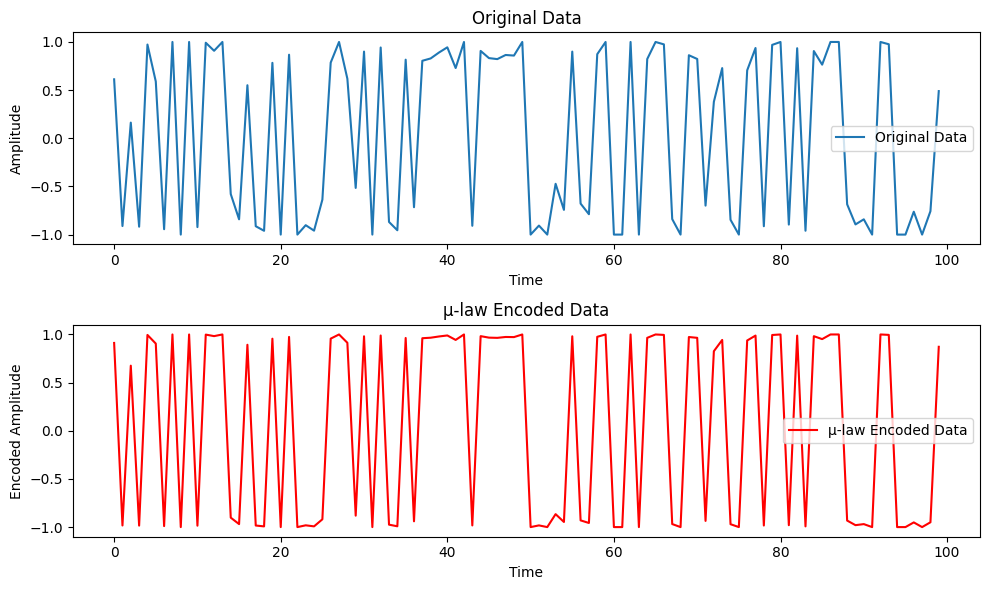

In [30]:
# Visualize a few random samples from the dataset
visualize_sample(data_segment, mu=mu)

### Optimizer and Loss Function

5 Points

In [31]:
from torch.optim import Adam
#TODO

# Define the optimizer and loss function
def get_optimizer_and_loss(model, learning_rate=1e-4):
    """
    Returns the Adam optimizer and CrossEntropy loss function.

    Parameters:
    - model: The neural network model (e.g., WaveNet).
    - learning_rate: The learning rate for the optimizer.

    Returns:
    - optimizer: Adam optimizer.
    - loss_fn: CrossEntropyLoss function.
    """
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    return optimizer, loss_fn

## Training

10 Points

In [32]:
#TODO
def train(model, optimizer, loss_fn, train_loader, batch_size=32, epochs=10, learning_rate=1e-4, device='cpu'):
    """
    Train the model on the provided dataset.
    """
    model.train()

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        for batch_idx, batch in enumerate(train_loader):
            # Original continuous inputs/targets in [-1, 1]
            inputs = batch["src"].to(device)   # [B, T_in]
            targets = batch["tgt"].to(device)  # [B, T_tgt]

            # ---- NEW: quantize to integer class indices 0..(model.n_category-1) ----
            inputs_q = torch.clamp(
                torch.floor((inputs + 1) * (model.n_category / 2)),
                0, model.n_category - 1
            ).long()
            targets_q = torch.clamp(
                torch.floor((targets + 1) * (model.n_category / 2)),
                0, model.n_category - 1
            ).long()
            # ------------------------------------------------------------------------

            optimizer.zero_grad()

            # Forward pass through WaveNet; expects integer indices
            output = model(inputs_q)  # [B, C, T_out]
            # print(f'output shape is: {output.shape}')

            # ---- NEW: put classes in last dim and align time dimension with targets ----
            output = output.permute(0, 2, 1)  # [B, T_out, C]

            T_out = output.size(1)
            T_tgt = targets_q.size(1)

            # Crop to common time dimension
            if T_tgt > T_out:
                targets_q = targets_q[:, :T_out]
            elif T_tgt < T_out:
                output = output[:, :T_tgt, :]

            # Now shapes: output [B, T, C], targets_q [B, T]
            output = output.reshape(-1, output.size(-1))  # [B*T, C]
            targets_q = targets_q.reshape(-1)             # [B*T]
            # print(f'output shape after flattening: {output.shape}')
            # print(f'targets shape after flattening: {targets_q.shape}')
            # ---------------------------------------------------------------------------

            # CrossEntropy expects [N, C] logits and [N] integer targets
            loss = loss_fn(output, targets_q)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(output, 1)
            epoch_total += targets_q.size(0)
            epoch_correct += (predicted == targets_q).sum().item()

            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100.0 * epoch_correct / epoch_total

        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return model, epoch_losses, epoch_accuracies

In [33]:
# Train the model and get losses and accuracies
batch_size=32
epochs=100
learning_rate=1e-4

optimizer, loss_fn = get_optimizer_and_loss(model, learning_rate=1e-4)

trained_model, losses, accuracies = train(model, optimizer, loss_fn, train_loader, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, device=device)

Epoch [1/100], Batch [0/32], Loss: 4.8517
Epoch [1/100], Average Loss: 4.8475, Accuracy: 3.33%
Epoch [2/100], Batch [0/32], Loss: 4.8422
Epoch [2/100], Average Loss: 4.8308, Accuracy: 27.77%
Epoch [3/100], Batch [0/32], Loss: 4.8109
Epoch [3/100], Average Loss: 4.7527, Accuracy: 36.65%
Epoch [4/100], Batch [0/32], Loss: 4.6406
Epoch [4/100], Average Loss: 4.2441, Accuracy: 35.33%
Epoch [5/100], Batch [0/32], Loss: 3.5925
Epoch [5/100], Average Loss: 3.1003, Accuracy: 35.30%
Epoch [6/100], Batch [0/32], Loss: 2.8050
Epoch [6/100], Average Loss: 2.6929, Accuracy: 35.30%
Epoch [7/100], Batch [0/32], Loss: 2.6482
Epoch [7/100], Average Loss: 2.5460, Accuracy: 35.31%
Epoch [8/100], Batch [0/32], Loss: 2.4849
Epoch [8/100], Average Loss: 2.4346, Accuracy: 35.30%
Epoch [9/100], Batch [0/32], Loss: 2.4152
Epoch [9/100], Average Loss: 2.3439, Accuracy: 35.30%
Epoch [10/100], Batch [0/32], Loss: 2.3068
Epoch [10/100], Average Loss: 2.2597, Accuracy: 35.30%
Epoch [11/100], Batch [0/32], Loss: 2.1

## Plot losses

5 Points

In [34]:
def plot_losses(trainLoss,Epochs):
#TODO
    """
    Plots the training loss over the epochs.

    Parameters:
    - trainLoss: List of training loss values for each epoch.
    - Epochs: Number of epochs in the training process.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Epochs + 1), trainLoss, label='Training Loss', color='blue')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

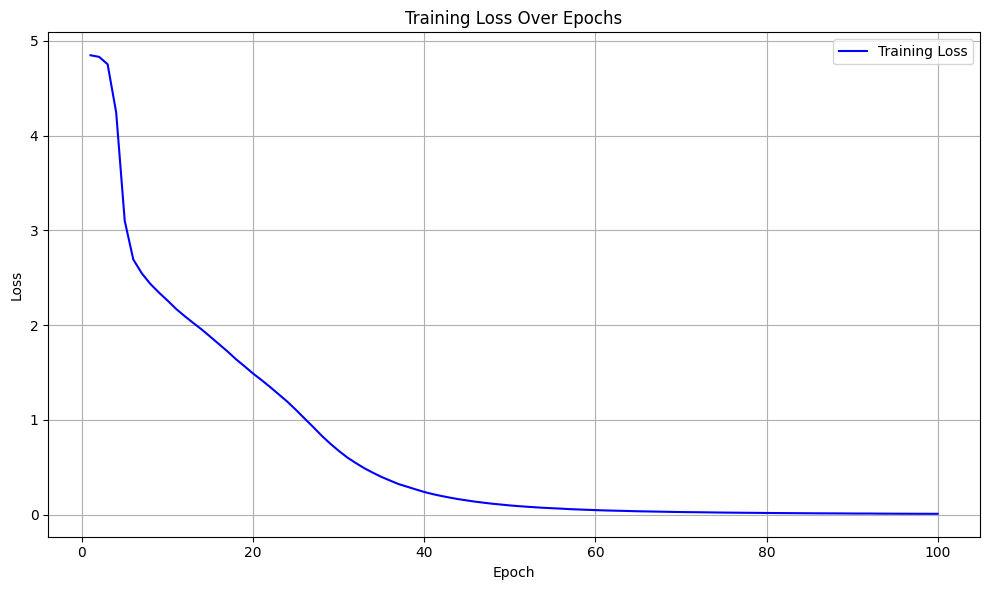

In [35]:
plot_losses(losses, Epochs=epochs)

## Save the model

5 Points


In [36]:
#TODO
def save_model(model, filename="wavenet_model.pth"):
    """
    Saves the trained model to a file.

    Parameters:
    - model: The trained model.
    - filename: The file path to save the model (default is 'wavenet_model.pth').
    """
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

In [37]:
save_model(trained_model, filename="/kaggle/working/wavenet_model.pth")

Model saved to /kaggle/working/wavenet_model.pth


## Generate Audio using trained model

5 Points

In [38]:
#TODO
def generate_audio(model, input_sequence, num_samples=100, device='cpu'):
    """
    Generate audio samples autoregressively using the trained model.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)

    with torch.no_grad():
        # Move the input to the correct device and ensure integer indices
        input_sequence = input_sequence.long().to(device)

        # Ensure a batch dimension
        if input_sequence.dim() == 1:
            generated_audio = input_sequence.unsqueeze(0)  # [1, T]
        elif input_sequence.dim() == 2:
            generated_audio = input_sequence  # [B, T]
        else:
            raise ValueError("input_sequence must be a 1D or 2D tensor")

        # Generate audio samples one by one
        for _ in range(num_samples):
            # Generate the next sample
            output = model(generated_audio)  # [B, C, T]
            last_logits = output[:, :, -1]  # [B, C]

            # Get the predicted class (the most likely next sample)
            _, predicted = torch.max(last_logits, dim=1)  # [B]
            predicted = predicted.unsqueeze(1)  # [B, 1]

            # Append the predicted sample to the generated audio
            generated_audio = torch.cat((generated_audio, predicted), dim=1)

    return generated_audio.squeeze(0)  # Remove batch dimension if B == 1

In [55]:
start_sequence = torch.randint(0, n_category, (seq_len_segment,))
generated_audio = generate_audio(trained_model, start_sequence, num_samples=10000, device=device)

# Question 2: Pixel CNN / Pixel RNN (Optional)

In this question, we explore **deep autoregressive models** for image generation, focusing on PixelCNN and PixelRNN.  

Natural images are high-dimensional and exhibit strong spatial correlations between neighboring pixels. The **PixelRNN** aims to model the **full joint distribution** of pixel intensities, enabling exact likelihood computation and realistic image generation.  

Unlike VAEs or GANs, which rely on latent variables or adversarial training, PixelRNN treats the **image as a sequence of pixels** and directly models:  

$$
p(\mathbf{x}) = \prod_{i=1}^{N} p(x_i \mid x_1, x_2, \ldots, x_{i-1})
$$

Here, each pixel \(x_i\) is conditioned on all previously generated pixels, following a fixed **raster-scan order** (top-left → bottom-right). This transforms image modeling into a **sequence modeling task**, allowing recurrent neural networks (RNNs) to capture long-range spatial dependencies.  

---

### Core Idea

PixelRNN introduces **two-dimensional LSTM architectures** to preserve autoregressive dependencies in images:

- **Row LSTM:** Processes the image row by row (left-to-right), with recurrent connections across both rows and columns.  
- **Diagonal Bi-LSTM:** Processes pixels along diagonals, increasing the receptive field to include all previously generated pixels.  

To maintain causality across color channels, each pixel’s RGB values are generated sequentially (R → G → B).  

![PixelRNN Architecture](image.png)

---

### Architectural Components

1. **Masked Convolutions**  
   Convolutional filters are masked (type A or B) to prevent access to future pixels or channels during training.  

2. **Residual Connections**  
   Stacked recurrent layers use residual links to facilitate gradient flow in deep networks.  

3. **Discrete Softmax Output**  
   Each pixel channel is modeled as a categorical distribution over 256 intensity values, allowing exact log-likelihood computation.  

4. **Loss Function**  
   The training objective is the **negative log-likelihood** of the true pixels under the predicted distributions:

$$
\mathcal{L} = -\sum_i \log p(x_i \mid x_{<i})
$$

---

### Sampling and Generation

Image generation in PixelRNN is **fully autoregressive**:

1. Start at the top-left pixel.  
2. Sequentially sample each pixel from its predicted conditional distribution.  
3. Repeat until the entire image is generated.  

This method produces coherent, high-quality images but is computationally intensive, as each pixel depends on all previously generated pixels.  

---

**Reference:** [PixelRNN Paper (2016)](https://arxiv.org/abs/1601.06759)


## load Cifar10

5 Points

In [40]:
import os
import math
import struct
from typing import List, Tuple
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

#TODO

IMAGE_SIZE = None
NUM_CLASSES = None
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = None
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = None


def _read_cifar10_binary_file(path: str) -> List[Tuple[int, np.ndarray]]:
    """
    Reads a single CIFAR-10 binary file and returns a list of (label, image_array)
    where image_array is HxWxC uint8 (32x32x3).
    CIFAR-10 binary format: 1 byte label followed by 3072 bytes image (R(1024), G(1024), B(1024))
    """
    records = []
    record_size = 1 + 32 * 32 * 3
    with open(path, 'rb') as f:
        while True:
            bytes_read = f.read(record_size)
            if not bytes_read:
                break
            if len(bytes_read) != record_size:
                raise ValueError(f"Unexpected record size in {path}: {len(bytes_read)} bytes")
            # first byte is label
            label = bytes_read[0]
            img_flat = np.frombuffer(bytes_read[1:], dtype=np.uint8)
            # image is stored as [R..1024, G..1024, B..1024] each row-major for 32x32
            # reshape to (3, 32, 32) then transpose to (32, 32, 3)
            depth_major = img_flat.reshape((3, 32, 32))
            img = np.transpose(depth_major, (1, 2, 0))  # H, W, C
            records.append((int(label), img))
    return records

class CIFAR10BinaryDataset(Dataset):
    """
    Dataset that reads the CIFAR-10 binary files into memory (list of (label, image)).
    Applies transforms (train/eval) provided in init.
    """
    def __init__(self, data_dir: str, files: List[str], transform=None):
        """
        data_dir: directory containing the CIFAR-10 binary files.
        files: list of filenames (basename) to read from data_dir.
        transform: torchvision transform to apply to PIL image (or custom transform).
        """
        self.data_dir = data_dir
        self.files = files
        self.transform = transform

        # Load all records into memory (50k images is fine)
        self.records: List[Tuple[int, np.ndarray]] = []
        for fname in files:
            path = os.path.join(data_dir, fname)
            if not os.path.exists(path):
                raise ValueError(f"Failed to find file: {path}")
            self.records.extend(_read_cifar10_binary_file(path))

        if len(self.records) == 0:
            raise ValueError("No records loaded from CIFAR files.")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        label, img_np = self.records[idx]
        # Convert to PIL Image (expects HxW or HxWxC)
        img = Image.fromarray(img_np)  # mode='RGB'
        if self.transform:
            img = self.transform(img)
        # After transforms, we expect a torch.FloatTensor image of shape [C, H, W]
        # Return label as long tensor
        return img, torch.tensor(label, dtype=torch.long)


class PerImageStandardization:
    """
    Mimics TensorFlow's per_image_standardization:
      (x - mean) / max(stddev, 1.0/sqrt(N))
    Works on a torch tensor image with shape (C, H, W) and dtype=float32 in range [0,1] or raw values.
    We'll expect inputs are float tensors in range [0,1].
    """
    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        # tensor: C x H x W
        if not torch.is_floating_point(tensor):
            tensor = tensor.float()
        mean = tensor.mean()
        std = tensor.std()
        # N = number of pixels * channels
        N = tensor.numel()
        std_min = 1.0 / math.sqrt(N)
        std_adj = max(std.item(), std_min)
        return (tensor - mean) / std_adj


def _train_transform():
    """
    Returns torchvision transform for training (distortions similar to TF code):
    - Random crop to IMAGE_SIZE x IMAGE_SIZE from 32x32 image
    - Random horizontal flip
    - Random brightness and contrast (approximate TF random_brightness/random_contrast)
    - Convert to tensor (0..1)
    - Per-image standardization
    """
    # ColorJitter's brightness and contrast ranges take a factor. TF used:
    # random_brightness with max_delta=63 (on [0,255]) => approx +/- 0.25 in normalized 0..1
    # random_contrast lower=0.2 upper=1.8 => matches contrast jitter factor
    color_jitter = transforms.ColorJitter(brightness=0.25, contrast=(0.2, 1.8))
    return transforms.Compose([
        transforms.RandomCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        color_jitter,
        transforms.ToTensor(),  # gives C x H x W, float in [0,1]
        PerImageStandardization(),
    ])


def _eval_transform():
    """
    Returns transform for evaluation:
     - center crop / pad to IMAGE_SIZE x IMAGE_SIZE (TF used resize_image_with_crop_or_pad which crops center)
     - Convert to tensor and per-image standardize
    """
    # For 32->24 center crop:
    return transforms.Compose([
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        PerImageStandardization(),
    ])


def get_train_loader(data_dir: str, batch_size: int, num_workers: int = 16, shuffle: bool = True):
    """
    Returns a DataLoader for training (reads data_batch_1..5).
    """
    #TODO

    return loader


def get_eval_loader(data_dir: str, batch_size: int, num_workers: int = 8, eval_data: bool = True):
    """
    Returns a DataLoader for evaluation.
    If eval_data==False it reads training batches (data_batch_1..5) else test_batch.bin
    """
    #TODO

    return loader


## Diagonal LSTM and Masked Convolution

20 Points

In [41]:
import logging
from typing import Optional, Tuple
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")
logger = logging.getLogger(__name__)

DEFAULT_DATA_FORMAT = "NHWC"

def _is_nchw(x: torch.Tensor) -> bool:
    return x.dim() == 4 and x.shape[1] <= 4 and x.shape[2] > 4  # heuristic; not perfect

def ensure_nhwc(x: torch.Tensor) -> torch.Tensor:
    """Return tensor in NHWC layout (B,H,W,C)."""
    if x.dim() != 4:
        raise ValueError("Expect 4D tensor")
    # If likely NCHW (N,C,H,W) convert to NHWC
    if x.shape[1] <= 4 and x.shape[2] > 4:
        return x.permute(0, 2, 3, 1).contiguous()
    return x

def ensure_nchw(x: torch.Tensor) -> torch.Tensor:
    """Return tensor in NCHW layout (B,C,H,W)."""
    if x.dim() != 4:
        raise ValueError("Expect 4D tensor")
    # If likely NHWC convert to NCHW
    if x.shape[3] <= 4 and x.shape[1] > 4:
        return x.permute(0, 3, 1, 2).contiguous()
    if x.shape[1] <= 4 and x.shape[2] > 4:
        # ambiguous, assume NCHW already
        return x
    # assume NHWC (B,H,W,C)
    if x.shape[3] <= 4:
        return x.permute(0, 3, 1, 2).contiguous()
    return x

def get_shape(inputs: torch.Tensor):
    """Return python list-style shape similar to TF's .as_list()."""
    return list(inputs.size())

# ---------------------------
# skew / unskew (supports NHWC and NCHW; works on NHWC primarily)
# ---------------------------
def skew(inputs: torch.Tensor, scope: str = "skew") -> torch.Tensor:
    """
    The skew function performs a transformation on a 4D tensor,
    either in NHWC format (Batch, Height, Width, Channels) or NCHW format (Batch, Channels, Height, Width). 
    The goal of skewing is to shift the data from its original height-wise structure into a diagonal format. 
    Specifically, the function combines the height and width dimensions in a way that the resulting tensor has a width of W + H - 1,
    where W is the width of the input tensor and H is the height.
    Accepts NHWC ([B,H,W,C]) or NCHW ([B,C,H,W]) tensors.
    Returns NHWC tensor with new width = W + H - 1
    """
    #TODO

    # if input was NCHW convert outputs back to NCHW style? The code returns NHWC.
    if was_nchw:
        # convert to NCHW before returning to be consistent with conv2d upstream expectations
        return outputs.permute(0, 3, 1, 2).contiguous()  # [B, C, H, new_width]
    return outputs  # NHWC

def unskew(inputs: torch.Tensor, width: Optional[int] = None, scope: str = "unskew") -> torch.Tensor:
    """
    The unskew function performs the reverse of the skew operation. 
    It takes a skewed tensor and "un-skews" it back to its original shape.
    If NCHW is provided, it will be converted to NHWC internally and returns NHWC.
    """
    #TODO

    if was_nchw:
        return outputs.permute(0, 3, 1, 2).contiguous()
    logger.debug(f"[unskew] {scope} : -> {outputs.shape}")
    return outputs

# ---------------------------
# conv2d with optional mask (mask type None/'A'/'B')
# ---------------------------
class MaskedConv2d(nn.Module):
    """
    A conv2d that mimics TF behavior with variable creation and masking.
    The module expects inputs either in NHWC or NCHW; internally we run conv in NCHW.
    weights_shape = [kernel_h, kernel_w, in_channels, out_channels] (TF style).
    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, int],
                 mask_type: Optional[str] = None,
                 stride: Tuple[int, int] = (1, 1),
                 padding: str = "SAME",
                 bias: bool = True,
                 weights_initializer=None,   
                 name: str = "conv2d"):
        super().__init__()
        self.kernel_h, self.kernel_w = kernel_size
        self.mask_type = mask_type.lower() if mask_type is not None else None
        self.stride = stride
        self.padding = padding
        self.name = name

        # Create weight parameter in PyTorch conv format: [out_channels, in_channels, kh, kw]
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, self.kernel_h, self.kernel_w))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

        # Initialize weights (Xavier uniform by default)
        nn.init.xavier_uniform_(self.weight)

        # Precompute mask if needed (create in TF ordering then transpose to PyTorch ordering)
        if self.mask_type is not None:
            mask = np.ones((self.kernel_h, self.kernel_w, in_channels, out_channels), dtype=np.float32)
            center_h = self.kernel_h // 2
            center_w = self.kernel_w // 2
            mask[center_h, center_w + 1:, :, :] = 0.
            mask[center_h + 1:, :, :, :] = 0.
            if self.mask_type == 'a':
                mask[center_h, center_w, :, :] = 0.
            # convert mask to shape [out, in, kh, kw] for direct multiplication with self.weight
            mask = mask.transpose(3, 2, 0, 1).copy()
            self.register_buffer('mask', torch.tensor(mask))
        else:
            self.mask = None

    def forward(self, inputs: torch.Tensor):
        # Accept NHWC or NCHW. Convert to NCHW for conv
        #TODO

        # return in same layout as input
        if not is_nchw:
            out = out.permute(0, 2, 3, 1).contiguous()
        logger.debug(f"[conv2d_{self.mask_type}] {self.name} : {inputs.shape} -> {out.shape}")
        return out

# conv1d implemented via conv2d with kernel_w = 1
class MaskedConv1d(MaskedConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=(1,1), padding="SAME", mask_type=None, bias=True, name="conv1d"):
        # kernel_size is int (height)
        super().__init__(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=(kernel_size, 1),
                         mask_type=mask_type,
                         stride=stride,
                         padding=padding,
                         bias=bias,
                         name=name)

# ---------------------------
# Diagonal LSTM Cell
# ---------------------------
class DiagonalLSTMCell(nn.Module):
    """
    Diagonal LSTM Cell equivalent converted from TF.
    - hidden_dims: number of hidden channels per spatial row
    - height: number of rows
    - channel: input channels (for conv1d s_to_s)
    """
    def __init__(self, hidden_dims: int, height: int, channel: int):
        super().__init__()
        self._hidden_dims = hidden_dims
        self._height = height
        self._channel = channel
        self._num_units = hidden_dims * height
        self._state_size = self._num_units * 2
        self._output_size = self._num_units

        # conv to compute s_to_s (2x1 conv as in TF conv1d)
        # We'll implement as a Conv2d with kernel (2,1) operating on [B, hidden_dims, height, 1]
        # But conv1d in TF used input channels = hidden_dims; output = 4*hidden_dims
        # Use groups=1
        self.s_to_s_conv = MaskedConv1d(in_channels=self._hidden_dims, out_channels=4*self._hidden_dims, kernel_size=2, padding="SAME", name='s_to_s')

    def forward(self, i_to_s: torch.Tensor, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        i_to_s: [B, 4 * height * hidden_dims]
        state: [B, 2 * num_units] where num_units = height * hidden_dims
        returns: h (B, height*hidden_dims), new_state (B, 2*num_units)
        """
        #TODO

        return h, new_state

# ---------------------------
# diagonal_lstm (sequence loop)
# ---------------------------
def diagonal_lstm(inputs: torch.Tensor, conf, scope: str = 'diagonal_lstm') -> torch.Tensor:
    """
    inputs: NHWC or NCHW. The function follows TF flow:
      - skew inputs -> conv2d 1x1 to produce input_to_state (skewed), transpose to [B, W, H, 4*hidden_dims]
      - reshape to rnn_inputs [B, W, H*4*hidden_dims] and iterate over width dimension
    conf must provide: hidden_dims (int), use_dynamic_rnn (bool optional)
    Returns: outputs in NHWC shape [B, H, W, hidden_dims]
    """
    #TODO


    if was_nchw:
        # convert back to NCHW to be consistent with upstream expectations
        return outputs.permute(0, 3, 1, 2).contiguous()
    return outputs

# ---------------------------
# diagonal_bilstm
# ---------------------------
def diagonal_bilstm(inputs: torch.Tensor, conf, scope: str = 'diagonal_bilstm') -> torch.Tensor:
    """
    Compose forward diagonal_lstm and backward diagonal_lstm then sum appropriately (as TF).
    If conf.use_residual is True, apply 1x1 conv residuals and add to inputs.
    Returns: sum of forward and backward outputs with backward last column zeroed and shifted similar to TF.
    """
    #TODO

    return out_fw + out_bw


In [42]:
import os
import glob
import logging
from typing import Optional, Dict, Any, Iterable

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

logger = logging.getLogger(__name__)
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")


class Statistic:
    """
    the Statistic helper.

    Args:
        model: torch.nn.Module to save/load state_dict from.
        optimizer: optional torch.optim.Optimizer to save/load state.
        data_tag: str label used in TensorBoard scalar names .
        model_dir: directory where checkpoints and logs will be written.
        test_step: not used internally here but kept for API similarity (you can use it externally).
        max_to_keep: how many checkpoints to keep; older are deleted.
        device: device to load tensors to when loading checkpoints (default: cpu).
    """
    def __init__(
        self,
        model: nn.Module,
        optimizer: Optional[torch.optim.Optimizer],
        data_tag: str,
        model_dir: str,
        test_step: int,
        max_to_keep: int = 20,
        device: Optional[torch.device] = None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.data_tag = data_tag
        self.model_dir = model_dir
        self.test_step = test_step
        self.max_to_keep = max_to_keep
        self.device = device if device is not None else torch.device("cpu")

        # internal counter t
        self.t = 0

        # tensorboard writer
        log_dir = os.path.join("logs", self.model_dir)
        os.makedirs(log_dir, exist_ok=True)
        self.writer = SummaryWriter(log_dir=log_dir)

        # Ensure model_dir exists for checkpoints
        os.makedirs(self.model_dir, exist_ok=True)

        # Optionally keep a list of saved checkpoints on disk (sorted)
        self._refresh_checkpoint_list()

        # call reset to initialize whatever you want (kept for API parity)
        self.reset()

        logger.info("Statistic initialized. logs -> %s, checkpoints -> %s", log_dir, self.model_dir)

    def reset(self):
        """
        Override or extend if you need to accumulate running statistics.
        """
        # user can extend this method if they want to keep rolling averages, etc.
        pass

    def _refresh_checkpoint_list(self):
        """
        Internal helper: update the cached list of checkpoint paths sorted by step (ascending).
        """
        pattern = os.path.join(self.model_dir, "checkpoint_*.pt")
        ckpts = glob.glob(pattern)
        # parse t from filename checkpoint_{t}.pt
        def _t_from_name(p):
            try:
                base = os.path.basename(p)
                t_str = base.replace("checkpoint_", "").replace(".pt", "")
                return int(t_str)
            except Exception:
                return -1
        ckpts_sorted = sorted(ckpts, key=_t_from_name)
        self._checkpoints = ckpts_sorted

    def _prune_checkpoints(self):
        """
        Keep only the last `max_to_keep` checkpoints, remove older ones.
        """
        self._refresh_checkpoint_list()
        if self.max_to_keep is None:
            return
        while len(self._checkpoints) > self.max_to_keep:
            old = self._checkpoints.pop(0)
            try:
                os.remove(old)
                logger.info("Removed old checkpoint: %s", old)
            except OSError:
                logger.warning("Failed to remove old checkpoint: %s", old)

    def on_step(self, train_l: float, test_l: float):
        """
        Called at end of a step (or epoch) to increment counter, write summaries, save checkpoints and reset accumulators.
        """
        # increment counter first
        self.t += 1

        # write summaries
        self.inject_summary({'train_l': train_l, 'test_l': test_l}, self.t)

        # save model
        self.save_model(self.t)

        # reset accumulators if any
        self.reset()

    def get_t(self) -> int:
        """Return current step counter."""
        return int(self.t)

    def inject_summary(self, tag_dict: Dict[str, float], t: Optional[int] = None):
        """
        Write scalar summaries to TensorBoard.
        tag_dict: mapping of tag->value, e.g. {'train_l': 0.5}
        t: step (if None uses current internal t)
        """
        step = self.t if t is None else int(t)
        for tag, value in tag_dict.items():
            full_tag = f"{self.data_tag}/{tag}"
            # ensure value is a python float
            try:
                val = float(value)
            except Exception:
                val = float(value.item()) if hasattr(value, "item") else float(value)
            self.writer.add_scalar(full_tag, val, step)
        # flush may be helpful to make summary available quickly
        self.writer.flush()

    def save_model(self, t: Optional[int] = None, extra_state: Optional[Dict[str, Any]] = None):
        """
        Save checkpoint for model (+ optimizer if supplied) and the internal counter 't'.
        extra_state: optional mapping of additional items to store (e.g., scheduler state).
        """
        step = self.t if t is None else int(t)
        ckpt_name = os.path.join(self.model_dir, f"checkpoint_{step}.pt")
        state = {
            't': step,
            'model_state': self.model.state_dict()
        }
        if self.optimizer is not None:
            state['optimizer_state'] = self.optimizer.state_dict()
        if extra_state:
            state['extra'] = extra_state

        # save atomically
        tmp_name = ckpt_name + ".tmp"
        torch.save(state, tmp_name)
        os.replace(tmp_name, ckpt_name)
        logger.info("Saved checkpoint: %s", ckpt_name)

        # refresh and prune
        self._refresh_checkpoint_list()
        self._prune_checkpoints()        

    def load_model(self, checkpoint_path: Optional[str] = None, map_location: Optional[torch.device] = None) -> bool:
        """
        Load the latest checkpoint (if checkpoint_path is None) or load the provided checkpoint file.
        Returns True if load succeeded, False otherwise.
        map_location: device to map the checkpoint tensors onto (default: self.device)
        """
 
        map_location = map_location or self.device

        if checkpoint_path is None:
            # find latest checkpoint
            self._refresh_checkpoint_list()
            if not self._checkpoints:
                logger.info("No checkpoints found in %s", self.model_dir)
                return False
            checkpoint_path = self._checkpoints[-1]

        if not os.path.exists(checkpoint_path):
            logger.warning("Checkpoint path does not exist: %s", checkpoint_path)
            return False

        logger.info("Loading checkpoint: %s", checkpoint_path)
        ckpt = torch.load(checkpoint_path, map_location=map_location)

        # load model state
        if 'model_state' in ckpt:
            try:
                self.model.load_state_dict(ckpt['model_state'])
            except Exception as e:
                logger.exception("Failed to load model_state: %s", e)
                return False
        else:
            logger.warning("Checkpoint missing 'model_state' key")

        # load optimizer state if present and optimizer available
        if 'optimizer_state' in ckpt and self.optimizer is not None:
            try:
                self.optimizer.load_state_dict(ckpt['optimizer_state'])
            except Exception as e:
                logger.exception("Failed to load optimizer_state: %s", e)
                # continue, not fatal

        # restore t if present
        if 't' in ckpt:
            self.t = int(ckpt['t'])
        else:
            # try to infer from filename
            base = os.path.basename(checkpoint_path)
            try:
                self.t = int(base.replace("checkpoint_", "").replace(".pt", ""))
            except Exception:
                self.t = 0

        logger.info("Load SUCCESS: %s (t=%d)", checkpoint_path, int(self.t))
        return True


    def close(self):
        """Close writer etc."""
        try:
            self.writer.close()
        except Exception:
            pass


2025-11-19 20:09:51.704167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763582991.984594      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763582992.062807      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [43]:
import logging
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")

import os
import sys
import pprint
import tarfile
import hashlib
import datetime
import numpy as np

from types import SimpleNamespace
from typing import Any, Dict, Iterable, Optional

# Python3 urllib
import urllib.request

from PIL import Image

pp = pprint.PrettyPrinter().pprint
logger = logging.getLogger(__name__)

# -------------------------
# Small helpers
# -------------------------
def mprint(matrix: Iterable[Iterable[float]], pivot: float = 0.5):
    """Pretty-print a binary-style matrix using '#' and ' ' like the original."""
    for array in matrix:
        print("".join("#" if i > pivot else " " for i in array))


def get_timestamp() -> str:
    """Return a filesystem-friendly timestamp string with local timezone info."""
    now = datetime.datetime.now().astimezone()
    return now.strftime('%Y_%m_%d_%H_%M_%S')


def binarize(images):
    """
    Binarize image(s) by sampling from Uniform(0,1) < pixel_value.
    Accepts a NumPy array or a PyTorch tensor. Returns same type as input (numpy or torch.FloatTensor).
    """
    try:
        import torch
        is_torch = torch.is_tensor(images)
    except Exception:
        is_torch = False

    if is_torch:
        # produce a tensor of same shape & device
        rand = torch.rand_like(images)
        return (rand < images).float()
    else:
        # assume numpy
        return (np.random.uniform(size=images.shape) < images).astype('float32')


# -------------------------
# Image saving
# -------------------------
def save_images(images, height: int, width: int, n_row: int, n_col: int,
                cmin: float = 0.0, cmax: float = 1.0, directory: str = "./", prefix: str = "sample"):
    """
    Save a grid of images to a single image file.
    - images: numpy array of shape (n_row*n_col, H, W) or (n_row*n_col, H, W, C)
              OR shaped (n_row, n_col, H, W) etc. This function will attempt to reshape sensibly.
    - height, width: single image H,W
    - n_row, n_col: grid layout
    """
    # convert torch -> numpy if needed
    try:
        import torch
        if torch.is_tensor(images):
            images = images.detach().cpu().numpy()
    except Exception:
        pass

    imgs = np.asarray(images)
    # handle shapes:
    # If flat list of images: (N, H, W) or (N, H, W, C)
    if imgs.ndim == 3:
        # grayscale stack
        N, H, W = imgs.shape
        C = 1
        imgs = imgs.reshape((N, H, W))
        imgs = imgs.reshape((n_row, n_col, H, W))
        imgs = imgs.transpose(1, 2, 0, 3).reshape((H * n_row, W * n_col))
        mode = 'L'
    elif imgs.ndim == 4:
        N, H, W, C = imgs.shape
        if C == 1:
            imgs = imgs.reshape((n_row, n_col, H, W))
            imgs = imgs.transpose(1, 2, 0, 3).reshape((H * n_row, W * n_col))
            mode = 'L'
        elif C == 3:
            # arrange into grid with channels last
            imgs = imgs.reshape((n_row, n_col, H, W, C))
            imgs = imgs.transpose(1, 2, 0, 3, 4).reshape((H * n_row, W * n_col, C))
            mode = 'RGB'
        else:
            # unsupported channel count: collapse or take first channel
            imgs = imgs[..., 0]
            imgs = imgs.reshape((n_row, n_col, H, W))
            imgs = imgs.transpose(1, 2, 0, 3).reshape((H * n_row, W * n_col))
            mode = 'L'
    else:
        raise ValueError("Unsupported image array shape: %s" % (imgs.shape,))

    # scale pixels from [cmin,cmax] to [0,255]
    if mode == 'L':
        norm = (imgs - cmin) / max((cmax - cmin), 1e-8)
        arr = np.clip(norm * 255.0, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(arr, mode='L')
    else:
        norm = (imgs - cmin) / max((cmax - cmin), 1e-8)
        arr = np.clip(norm * 255.0, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(arr, mode='RGB')

    filename = f'{prefix}_{get_timestamp()}.jpg'
    out_path = os.path.join(directory, filename)
    os.makedirs(directory, exist_ok=True)
    pil_img.save(out_path)
    logger.info("Saved image grid to %s", out_path)


# -------------------------
# Model / config helpers
# -------------------------
def get_model_dir(config, exceptions=None):
    """
    Robust replacement for TF-specific get_model_dir:
      - Accepts TF flags object (which stores flags under __flags) or argparse/Namespace/SimpleNamespace.
      - Builds a readable model dir name from config key/value pairs excluding `exceptions`.
      - If the generated name is too long, falls back to an md5 hash to keep path sane.
    """
    exceptions = set(exceptions or [])
    # Try TF-style flags first
    try:
        if hasattr(config, '__dict__') and '__flags' in config.__dict__:
            attrs = dict(config.__dict__['__flags'])
        else:
            # argparse.Namespace / SimpleNamespace / plain object
            attrs = dict(vars(config))
    except Exception:
        # as a last resort, try to use __dict__
        try:
            attrs = dict(config.__dict__)
        except Exception:
            attrs = {}

    # Filter out exceptions and None/empty values that are not informative
    items = []
    for k in sorted(attrs.keys()):
        if k in exceptions:
            continue
        if k.startswith('_'):
            continue
        v = attrs[k]
        if callable(v):
            vstr = v.__name__
        else:
            try:
                vstr = str(v)
            except Exception:
                vstr = repr(v)
        # shorten long values
        if len(vstr) > 40:
            vstr = hashlib.md5(vstr.encode('utf-8')).hexdigest()[:8]
        items.append(f"{k}={vstr}")

    if not items:
        name = "default"
    else:
        name = "_".join(items)

    # sanitize name (remove spaces, slashes)
    name = name.replace(" ", "").replace("/", "_").replace("\\", "_")

    # If too long, shorten using md5
    if len(name) > 180:
        name = hashlib.md5(name.encode("utf-8")).hexdigest()

    return os.path.join('checkpoints', name) + '/'


def preprocess_conf(conf):
    """
    Placeholder to keep API parity with your previous code.
    If you need to normalize or canonicalize flags/options, do it here.
    """
    # For argparse/Namespace we don't need to do anything by default.
    return conf


def check_and_create_dir(directory: str):
    """Create dir if not exists (logs)"""
    if not os.path.exists(directory):
        logger.info('Creating directory: %s' % directory)
        os.makedirs(directory)
    else:
        logger.info('Skip creating directory: %s' % directory)


def show_all_variables(model: Optional[Any] = None):
    """
    Print all trainable variables.
    If `model` is provided (torch.nn.Module), iterate its parameters.
    """
    try:
        import torch
        if model is None:
            logger.warning("No model passed to show_all_variables(model). Nothing to show.")
            return
        total_count = 0
        for idx, (name, param) in enumerate(model.named_parameters()):
            shape = tuple(param.shape)
            count = int(np.prod(shape))
            print("[%2d] %s %s = %s" % (idx, name, shape, count))
            total_count += count
        print("[Total] variable size: %s" % "{:,}".format(total_count))
    except Exception as e:
        logger.exception("show_all_variables failed: %s", e)

## Network
in this part we will impelement a neural network that can be configured to perform pixel-wise predictions, specifically for image generation tasks such as those in PixelCNN or PixelRNN models. This class supports both training and inference, and can generate outputs pixel-by-pixel in a raster scan order, leveraging various types of convolutions (standard and masked) and recurrent layers (e.g., LSTM).

25 Points

In [44]:
import os
import math
import logging
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

logger = logging.getLogger(__name__)
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")


class Network(nn.Module):
    """
    PyTorch Network class.
    """
    def __init__(self, conf, height: int, width: int, channel: int, device: Optional[torch.device] = None):
        super().__init__()
        logger.info("Building %s starts!" % conf.model)
        self.conf = conf
        self.data = conf.data
        self.height, self.width, self.channel = height, width, channel
        self.device = device if device is not None else (torch.device("cuda") if conf.use_gpu and torch.cuda.is_available() else torch.device("cpu"))

        # Data format decisions
        self.data_format = "NHWC" if conf.use_gpu else "NCHW"

        # Build layers - FIXED CHANNEL DIMENSIONS
        in_channels = channel

        # Calculate conv_out_channels based on residual connections
        if conf.use_residual and conf.model == "pixel_rnn":
            conv_out_channels = conf.hidden_dims * 2
        else:
            conv_out_channels = conf.hidden_dims

        # Input convolution
        self.conv_inputs = nn.Conv2d(in_channels, conv_out_channels, kernel_size=7, padding=3)

        # Build recurrent/conv layers
        self.recurrent_length = conf.recurrent_length
        self.out_recurrent_length = conf.out_recurrent_length

        if conf.model == "pixel_cnn":
            # For pixel_cnn, use masked convolutions with proper channel dimensions
            self.conv_blocks = nn.ModuleList()
            for idx in range(self.recurrent_length):
                in_ch = conv_out_channels if idx == 0 else conf.hidden_dims
                # Use regular conv2d for now - replace with masked conv if available
                self.conv_blocks.append(nn.Conv2d(in_ch, conf.hidden_dims, kernel_size=3, padding=1))
        else:
            # For pixel_rnn we will call diagonal_bilstm in forward()
            self.conv_blocks = None

        # Output recurrent layers (1x1 convs + ReLU)
        self.out_convs = nn.ModuleList()
        for idx in range(self.out_recurrent_length):
            in_ch = conf.hidden_dims if idx == 0 else conf.out_hidden_dims
            self.out_convs.append(nn.Conv2d(in_ch, conf.out_hidden_dims, kernel_size=1))

        # Final logits conv - FIXED: output should match input channels for binary prediction
        if channel == 1:
            # Single output logit per pixel
            in_ch = conf.out_hidden_dims if self.out_recurrent_length > 0 else conv_out_channels
            self.conv2d_out_logits = nn.Conv2d(in_ch, 1, kernel_size=1)
            self.loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
        else:
            # For RGB/categorical (not implemented in original)
            raise NotImplementedError("RGB branch not implemented (same as original).")

        # Optimizer (RMSProp) and grad clipping
        self.optimizer = optim.RMSprop(self.parameters(), lr=conf.learning_rate)
        self.grad_clip = conf.grad_clip

        # Move to device
        self.to(self.device)
        logger.info("Building %s finished!" % conf.model)

    def _to_nchw(self, x: torch.Tensor) -> torch.Tensor:
        """Convert incoming tensor to NCHW for internal conv ops."""
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        x = x.to(self.device)
        if x.dim() != 4:
            raise ValueError("Input must be 4D tensor")
        if self.data_format == "NHWC":
            # [B,H,W,C] -> [B,C,H,W]
            x = x.permute(0, 3, 1, 2).contiguous()
        return x.float()

    def _to_output_layout(self, x: torch.Tensor) -> torch.Tensor:
        """Convert internal outputs (NCHW) back to requested external layout."""
        if self.data_format == "NHWC":
            return x.permute(0, 2, 3, 1).contiguous()
        return x

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        #TODO

        # Return in external layout
        return self._to_output_layout(logits)

    def predict(self, images):
        """Predict probabilities for given images."""
        #TODO
        return probs_t.detach().cpu().numpy()

    def test(self, images, with_update: bool = False):
        """Compute loss for images, optionally update weights."""
        #TODO

        return float(loss_val.item())

    def generate(self, batch_size: int = 100):
        """Generate binary samples in raster order."""
        #TODO

        return samples

## Main

10 Points

In [45]:
import os
import logging
import argparse
import math
from types import SimpleNamespace

import numpy as np
from tqdm import trange
from itertools import islice

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# logging
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")
logger = logging.getLogger()
# default level set later by args

def parse_args():
    parser = argparse.ArgumentParser()
    # network
    parser.add_argument("--model", type=str, default="pixel_cnn", help="name of model [pixel_rnn, pixel_cnn]")
    parser.add_argument("--batch_size", type=int, default=100, help="size of a batch")
    parser.add_argument("--hidden_dims", type=int, default=16, help="dimesion of hidden states of LSTM or Conv layers")
    parser.add_argument("--recurrent_length", type=int, default=7, help="the length of LSTM or Conv layers")
    parser.add_argument("--out_hidden_dims", type=int, default=32, help="dimesion of hidden states of output Conv layers")
    parser.add_argument("--out_recurrent_length", type=int, default=2, help="the length of output Conv layers")
    parser.add_argument("--use_residual", action="store_true", default=False, help="whether to use residual connections or not")

    # training
    parser.add_argument("--max_epoch", type=int, default=100000, help="# of step in an epoch")
    parser.add_argument("--test_step", type=int, default=100, help="# of step to test a model")
    parser.add_argument("--save_step", type=int, default=1000, help="# of step to save a model")
    parser.add_argument("--learning_rate", type=float, default=1e-3, help="learning rate")
    parser.add_argument("--grad_clip", type=float, default=1.0, help="value of gradient to be used for clipping")
    parser.add_argument("--use_gpu", action="store_true", default=True, help="whether to use gpu for training")

    # data
    parser.add_argument("--data", type=str, default="mnist", help="name of dataset [mnist, cifar]")
    parser.add_argument("--data_dir", type=str, default="data", help="name of data directory")
    parser.add_argument("--sample_dir", type=str, default="samples", help="name of sample directory")

    # debug / misc
    parser.add_argument("--is_train", action="store_true", default=True, help="training or testing")
    parser.add_argument("--display", action="store_true", default=False, help="whether to display the training results or not")
    parser.add_argument("--log_level", type=str, default="INFO", help="log level [DEBUG, INFO, WARNING, ERROR, CRITICAL]")
    parser.add_argument("--random_seed", type=int, default=123, help="random seed for python")

    return parser.parse_args([]) # Pass an empty list to parse_args

def main():
    args = parse_args()
    # convert argparse Namespace to a conf-like SimpleNamespace (so older code expecting attributes works)
    conf = SimpleNamespace(**vars(args))

    # logging level
    logger.setLevel(conf.log_level)

    # random seeds
    np.random.seed(conf.random_seed)
    torch.manual_seed(conf.random_seed)
    if conf.use_gpu and torch.cuda.is_available():
        torch.cuda.manual_seed_all(conf.random_seed)

    # Build model dir and preprocess config if helper exists
    model_dir = get_model_dir(conf,
                              ['data_dir', 'sample_dir', 'max_epoch', 'test_step', 'save_step',
                               'is_train', 'random_seed', 'log_level', 'display'])
    preprocess_conf(conf)

    DATA_DIR = os.path.join(conf.data_dir, conf.data)
    SAMPLE_DIR = os.path.join(conf.sample_dir, conf.data, model_dir)

    check_and_create_dir(DATA_DIR)
    check_and_create_dir(SAMPLE_DIR)

    device = torch.device("cuda" if (conf.use_gpu and torch.cuda.is_available()) else "cpu")
    logger.info("Using device: %s", device)

    # 0. prepare datasets

    if conf.data == "cifar":
        #TODO
    else:
        raise ValueError("Unknown dataset: %s" % conf.data)

    try:
        stat = Statistic(network, network.optimizer, conf.data, model_dir, conf.test_step)
    except TypeError:
        # older Statistic signature variations: try with optimizer attr
        stat = Statistic(network, network.optimizer if hasattr(network, 'optimizer') else None, conf.data, model_dir, conf.test_step)

    # Try loading existing checkpoint
    stat.load_model()

    if conf.is_train:
        logger.info("Training starts!")
        initial_step = stat.get_t() if stat else 0
        iterator = trange(conf.max_epoch, ncols=70, initial=initial_step)

        for epoch in iterator:
            # 1. train

            # 2. test

            # 3. generate samples


if __name__ == "__main__":
    main()

IndentationError: expected an indented block after 'if' statement on line 84 (1987955360.py, line 86)